In [1]:
#Import npz data
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

In [2]:
metadata = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/musicnet_metadata.csv',index_col=0)

train_wav = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/df_test_wav_finc.csv',index_col=0)


In [3]:
#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)
#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

merged_train_data = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data = merged_train_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

merged_test_data = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data = merged_test_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)


In [4]:
#subset of dataset for only max 2 instruments

subset_list= ['Accompanied Cello','Accompanied Clarinet','Accompanied Violin','Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin', 'Violin and Harpsichord']
subset_merged_train_data = merged_train_data.loc[merged_train_data['ensemble'].isin(subset_list)]
subset_merged_test_data = merged_test_data.loc[merged_test_data['ensemble'].isin(subset_list)]

In [5]:
merged_train_data.shape

(320, 169)

In [6]:
#Get list of unique ensembles
ens_list = merged_train_data['ensemble'].unique()
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

In [7]:
#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}

#merged_train_data['ensemble'] = merged_train_data.ensemble.map(mapping)

merged_train_data["ensemble"] = merged_train_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data["ensemble"] = subset_merged_train_data["ensemble"].apply(lambda x: mapping[x])

merged_test_data["ensemble"] = merged_test_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data["ensemble"] = subset_merged_test_data["ensemble"].apply(lambda x: mapping[x])

C:\Users\Zhuang\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Zhuang\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
X_original_train = merged_train_data.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data.iloc[:,167:168]
y_original_test = merged_test_data.iloc[:,167:168]

In [9]:
#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y = pd.concat(y_frames , ignore_index=True)


In [10]:
#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet = y[ y['ensemble'] == 3 ].index
y.drop(index_violaquintet , inplace=True)
X.drop(index_violaquintet , inplace=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=101)


In [11]:
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(263, 168) (66, 168) (263, 1) (66, 1)


In [12]:
# Set some variables to hold test, dev, training and mini_train data.
test_data, test_labels = X[:56], y[:56]
dev_data, dev_labels = X[56:66], y[56:66]
train_data, train_labels = X_train[:263], y_train[:263]
mini_train_data, mini_train_labels = X_train[:10], y_train[:10]

In [13]:
print( mini_train_data.shape, mini_train_labels.shape, dev_data.shape, dev_labels.shape)

(10, 168) (10, 1) (10, 168) (10, 1)


In [14]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,20)


    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.599674
1                          2                              0.939955
2                          3                              0.977541
3                          4                              0.986315
4                          5                              0.989608
5                          6                              0.992340
6                          7                              0.993706
7                          8                              0.994794
8                          9                              0.995848
9                         10                              0.996592
10                        11                              0.997112
11                        12                              0.997456
12                        13                              0.997732
13                        14                              0.99

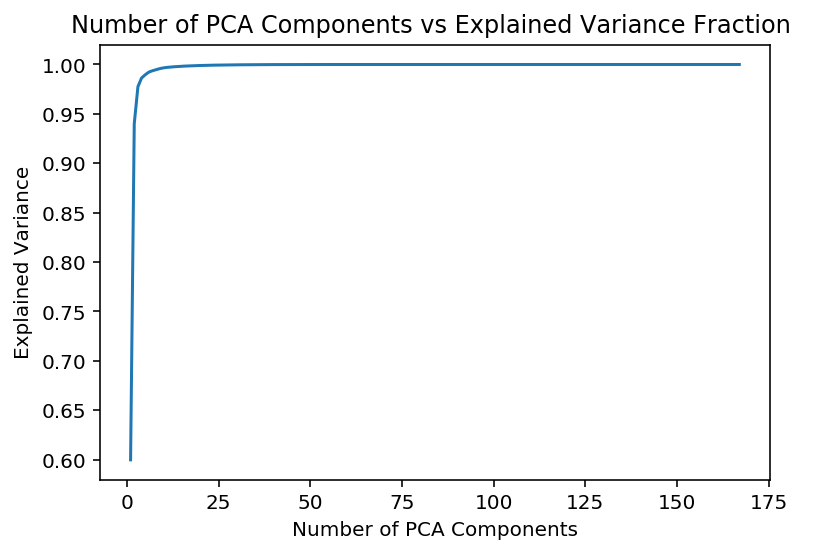

In [15]:
# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train)
    train_pca = pca.transform(X_train)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 167 i.e. one less than 168
all_possible_k = np.arange(1,168)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(train_data)
    train_pca = pca.transform(train_data)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()  

In [16]:
#Perform PCA with 15 components
pca=PCA(n_components = 15)

train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

In [17]:
C_values = np.logspace(-4, 4, 20)

def search_c(C_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in C_values:
        
        #Use Logistic Regression to produce model
        svm = SVC(kernel='linear', C = i)
        svm.fit(train_pca,y_train.values.ravel())
        y_pred_svm = svm.predict(test_pca)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_test, y_pred_svm, average='weighted'))
    
    #Find max index position for f1s and find the associated C-value for that
    best_C = C_values[f1s.index(max(f1s))]
        
    return best_C

#Run code for various C values to find answer of best C value
best_C = search_c(C_values)


In [18]:
best_C 

0.0018329807108324356

In [24]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid)
  
# fitting the model for grid search
grid.fit(train_pca, y_train.values.ravel())

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'rbf', 'poly']})

In [28]:
print(grid.best_params_)

{'C': 0.012742749857031334, 'gamma': 0.001, 'kernel': 'linear'}


In [29]:
grid.best_params_['C']

0.012742749857031334

In [30]:
grid.best_params_['gamma']

0.001

In [27]:
print(grid.best_estimator_)

SVC(C=0.012742749857031334, gamma=0.001, kernel='linear')


In [35]:

svm = make_pipeline(SVC(kernel='linear', C = best_C , gamma=1))

svm.fit(train_pca, y_train.values.ravel())
predictions = svm.predict(test_pca)
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

Accuracy score:  0.8939393939393939
F1 Score:  0.9297129073248477
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.86      1.00      0.93        31
           2       0.50      1.00      0.67         1
           4       1.00      1.00      1.00        11
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00 

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

    

#Run Confusion matrix and plot for rbf kernel SVM
conf_matrix = confusion_matrix(y_test, predictions) 
confusion_matrix_plot(conf_matrix)